In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import cwt,icwt,Wavelet
import time
import sys
import gc
from scipy.optimize import curve_fit
#--------------------------------------------------------------------------
machine_epsilon = sys.float_info.epsilon



In [ ]:
def gauss1(x, a1, b1, c1):
    return a1 * np.exp(-((x - b1)**2) / (2 * c1**2))



def cal_pp1(W):
    WW_abs=np.abs(W)
    WW_abs=WW_abs+np.mean(WW_abs)
    xu=np.linspace(0,W.shape[0]-1,W.shape[0])
    pp=np.zeros(W.shape[0])
    for i in range(W.shape[0]):
        prob_dist = WW_abs[i, :] / (np.sum(WW_abs[i, :]) + 1e-8)
        pp[i] = -np.sum(prob_dist * np.log(prob_dist + 1e-8))
    pp=1-(pp-np.min(pp))/(np.max(pp)-np.min(pp))

    xData = np.ravel(xu)
    yData = np.ravel(pp)
    mm = np.max(yData)   
    nn_index = np.argmax(yData)       
    b1_guess = xData[nn_index]        
    c1_guess = (np.max(xData) - b1_guess) / 3  
    initial_guess = [mm, b1_guess, c1_guess]
    param_bounds = ([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf])
    popt, pcov = curve_fit(gauss1, xData, yData, p0=initial_guess, bounds=param_bounds,maxfev=5000) 

    a1_fit, b1_fit, c1_fit = popt
    st1 = max(int(np.ceil(b1_fit - 3*c1_fit)), 0)
    ed1 = min(int(np.floor(b1_fit + 3*c1_fit)), W.shape[0]-1)
    return st1,ed1



In [ ]:

 
def new_method(W,st1,ed1,nu):
    W1=W[st1+1:ed1].copy()
    W4=W1.copy()
    W1_abs=np.abs(W1)
    I=W1_abs.sum(axis=0)
    I_min=np.min(I)
    I_max=np.max(I)
    I_norm=(I - I_min) / (I_max - I_min+machine_epsilon)
    I_1=W1_abs.copy()
    for i in range(W1.shape[0]):
        I_norm_1=I_norm.copy()
        W2_abs_f=W1_abs[i,:]
        W2_abs_f_min=np.min(W2_abs_f)
        W2_abs_f_max=np.max(W2_abs_f)
        W2_norm_f=(W2_abs_f - W2_abs_f_min) / (W2_abs_f_max - W2_abs_f_min+machine_epsilon)
        mask=I_norm_1>W2_norm_f
        I_norm_1[mask]=W2_norm_f[mask]
        I_1[i,:]=I_norm_1*(I_max - I_min)+I_min
    W3=W1/(I_1+machine_epsilon)
    W3_abs=np.abs(W3)
    #-------------------------------------------------------------------
    curve=np.zeros((nu))
    nnn=np.linspace(np.min(I_1), np.max(I_1),nu)
    ik=0
    for i in nnn:
        curve[ik]=np.sum(np.abs(W1_abs-i*W3_abs))
        if ik > 0:
            if curve[ik] > curve[ik - 1]:  
                break
        ik=ik+1
    #-------------------------------------------------------------------
    curve1=np.zeros((nu))
    if ik-2>0:
        nnn1=np.linspace(nnn[ik-2], nnn[ik],nu)
    else:
        nnn1=np.linspace(0, nnn[ik],nu)
    ik1=0
    for i in nnn1:
        curve1[ik1]=np.sum(np.abs(W1_abs-i*W3_abs))
        if ik1 > 0:
            if curve1[ik1] > curve1[ik1 - 1]:  
                break
        ik1=ik1+1
    if ik-1>0:
        k=nnn1[ik1-1]
    else:
        k=0
    #-------------------------------------------------------------------
    W3_k=W3*k
    W3_kabs=np.abs(W3_k)
    for i in range(W1.shape[0]):
        mask = W3_kabs[i,:]>W1_abs[i,:]
        W3_k[i,mask]=W1[i,mask]
    W4=W1-W3_k        
    W4_abs=np.abs(W4)
    W4=W4*np.max(I-I_min)/np.max(W4_abs.sum(axis=0))
    W4_4=W.copy()
    W4_4[:st1+1,:]=0
    W4_4[ed1:,:]=0
    W4_4[st1+1:ed1]=W4
    return W4_4




  
def zhang_thre(W,Lamda,A):
    WW_soft_new1=W.copy()
    WW_soft_new1_abs=np.abs(WW_soft_new1)
    for i in range(WW_soft_new1_abs.shape[0]):
        nn = WW_soft_new1_abs[i, :] >= Lamda[i]  
        WW_soft_new1_abs[i, nn]  = WW_soft_new1_abs[i, nn] -Lamda[i]*(A/np.max(WW_soft_new1_abs[i, :]))**(1/2)
        nn = WW_soft_new1_abs[i, :] < Lamda[i]  
        WW_soft_new1_abs[i, nn]=0
    WW=WW_soft_new1_abs* WW_soft_new1/np.abs(WW_soft_new1)
    return WW



 
def cal_thre(W_abs):
    N=W_abs.shape[1]
    Lamda=np.zeros(W_abs.shape[0])
    for i in range(W_abs.shape[0]):
        Lamda[i]=np.median(W_abs[i,:]) / 0.6745 * np.sqrt(2 * np.log(N))/np.log2(i+1+1)
    return Lamda



In [16]:
w=np.load('xx01.npy', allow_pickle=True)
w=w[1200:2200]
fs=500
w_max=np.max(w)
w_min=np.min(w)
w=2*(w-w_min)/(w_max-w_min)-1
 
loaded_data = np.load('Wave_noise_500.npz')
noise=loaded_data['Wave']
SN=loaded_data['SN']
t = loaded_data['t']
fs = loaded_data['fs']


In [ ]:
sss=noise.copy()
for i in range(sss.shape[0]):
    sss[i,:]=sss[i,:]+w
nv = 10
wavelet = Wavelet(wavelet='Morlet')
nuu=list([100,200,300,400,500])
Result=np.zeros((len(nuu),noise.shape[0],noise.shape[1]))
Time=np.zeros(len(nuu))
for nk in range(len(nuu)):
    gc.disable()  
    start_time = time.perf_counter()
    for i in range(noise.shape[0]):
        s=sss[i,:]
        W,scales= cwt(s, wavelet=wavelet,nv=nv)
        W_abs=np.abs(W)
        Lamda=cal_thre(W_abs)
        W_zhang=zhang_thre(W,Lamda,np.median(np.abs(s)))
        st1,ed1=cal_pp1(W)
        W4=new_method(W,st1,ed1,nuu[nk])
        Xii=np.zeros(W.shape)
        mask=(np.abs(W4)/W_abs>0)&(np.abs(W_zhang)/W_abs>0)
        Xii[mask]=1
        W4=Xii*W4
        w1=icwt(W4,wavelet=wavelet, nv=nv)
        Result[nk,i,:]= w1
    end_time = time.perf_counter()
    gc.enable()  
    Time[nk]=end_time - start_time
    print(end_time - start_time)


35.630953800000015
37.2160327
39.18279340000004
41.11645139999996
42.9190471


In [8]:
np.savez('Nuu_result_500.npz',Result=Result,Time=Time,nuu=nuu) 

In [17]:
loaded_data = np.load('Nuu_result_500.npz')
Result=loaded_data['Result']
Time=loaded_data['Time']
nuu=loaded_data['nuu']

In [18]:
n=noise.shape[0]
P_SN=np.zeros((len(nuu),n))
P_VA=np.zeros((len(nuu),n))
for xu in range(len(nuu)):
    for i in range(n):
        snr=10*np.log(np.sum(w**2)/np.sum((w-Result[xu,i,:])**2))
        P_SN[xu,i]=snr
        va=np.sqrt(np.sum((w-Result[xu,i,:])**2))
        P_VA[xu,i]=va
VA=SN.copy()
for i in range(noise.shape[0]):
    VA[i]=np.sqrt(np.sum(noise[i,:]**2))

In [19]:
for i in range(P_SN.shape[0]):
    print(np.mean(P_SN[i,:]))
print('------------------------')
for i in range(P_SN.shape[0]):
    print(np.mean(P_VA[i,:]))
print('------------------------')
print(Time/500)
print('------------------------')
print(np.mean(SN))
print(np.mean(VA))

29.24204811825552
29.24200997839365
29.24152464586779
29.240348004667535
29.23853509989672
------------------------
0.7428150222716268
0.7428167355419544
0.7428389271541969
0.7428897161008378
0.7429632121893885
------------------------
[0.07126191 0.07443207 0.07836559 0.0822329  0.08583809]
------------------------
-1.8131474856356602
3.4522785094903186


In [ ]:

NN=10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['font.size'] = NN  
plt.rcParams['axes.labelsize'] = NN  
plt.rcParams['axes.titlesize'] = NN 
plt.rcParams['xtick.labelsize'] = NN 
plt.rcParams['ytick.labelsize'] = NN  
plt.rcParams['legend.fontsize'] = NN  
plt.rcParams['axes.labelpad'] =.1
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'  


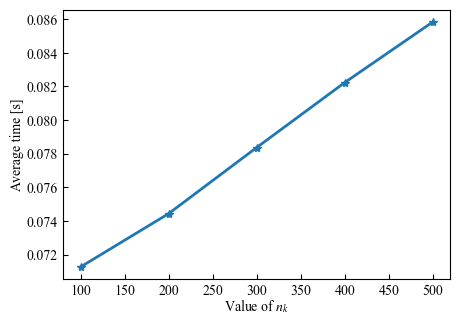

In [ ]:
plt.figure(figsize=(5,3.5))
plt.plot(nuu,Time/500,'-*',linewidth=2)
plt.xlabel('Value of '+r'$n_{k}$')
plt.ylabel('Average time [s]', labelpad=2)
# plt.savefig("fig14.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()


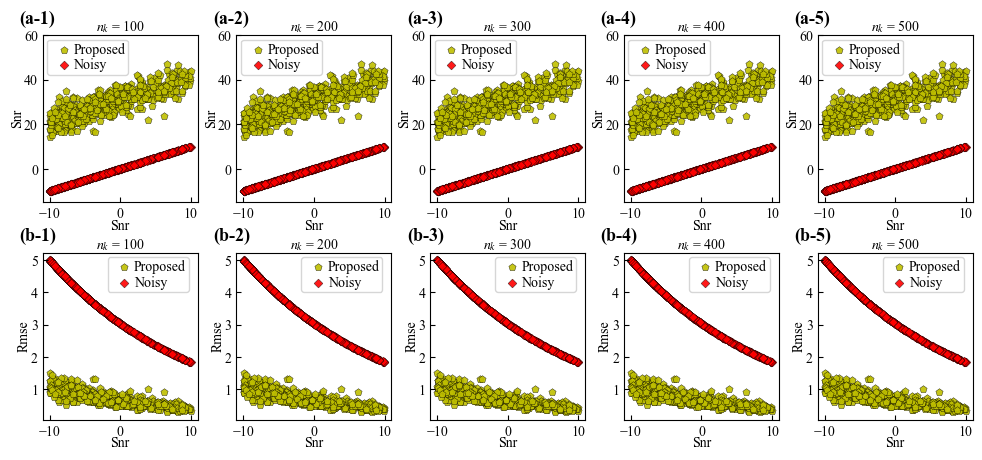

In [ ]:

ln = 0.3
sizes = 30
sizes1 = sizes - 10
axes = []
plt.figure(figsize=(12, 5))
for i in range(len(nuu)):
    ax1 = plt.subplot(2,5, i+1)
    # 第一个散点图，标签为"Proposed"
    plt.scatter(SN, P_SN[i, :],c='y', marker='p',s=sizes, alpha=0.9, 
                edgecolors='black', linewidths=ln, label='Proposed')
    plt.scatter(SN, SN, s=sizes1, c='r', marker="D", alpha=0.9, 
                edgecolors='black', linewidths=ln, label='Noisy')
    plt.xlabel('Snr', labelpad=-2)
    plt.ylabel('Snr', labelpad=0)
    plt.title(r'$n_{k}$'+' = '+str(nuu[i]), pad=-5)
    plt.ylim([-15, 60])
    
    plt.legend(loc='upper left', 
               bbox_to_anchor=(0.02, 0.98),  
               borderaxespad=0.1,  
               borderpad=0.2,     
               handletextpad=-0.3,  
               labelspacing=0.1)   
    
    ax2 = plt.subplot(2,5,  i+6)
  
    plt.scatter(SN, P_VA[i, :], c='y',marker='p',s=sizes, alpha=0.9, 
                edgecolors='black', linewidths=ln, label='Proposed')
    plt.scatter(SN, VA, s=sizes1, c='r', marker="D", alpha=0.9, 
                edgecolors='black', linewidths=ln, label='Noisy')
    plt.xlabel('Snr', labelpad=-2)
    plt.ylabel('Rmse', labelpad=0)
    # plt.title('n = '+str(nuu[i]), pad=-5)
    plt.title(r'$n_{k}$'+' = '+str(nuu[i]), pad=-5)
    # plt.ylim([-15, 60])
    
    plt.legend(loc='upper right', 
               bbox_to_anchor=(0.95, 0.98),  
               borderaxespad=0.1,  
               borderpad=0.2,      
               handletextpad=-0.3,  
               labelspacing=0.1)   

    axes.append((ax1, ax2))

labels = ['(a-1)', '(a-2)', '(a-3)', '(a-4)', '(a-5)', '(b-1)', '(b-2)', '(b-3)', '(b-4)', '(b-5)']
for i, (ax1, ax2) in enumerate(axes):
    ax1.text(-0.15, 1.15, labels[i], transform=ax1.transAxes, fontsize=NN+3,
            weight='bold', color='black', va='top', ha='left')
    ax2.text(-0.15, 1.15, labels[i+5], transform=ax2.transAxes, fontsize=NN+3,
            weight='bold', color='black', va='top', ha='left')

plt.subplots_adjust(wspace=0.25,hspace=0.3)
# plt.savefig("fig13.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()


In [ ]:
sss=noise.copy()
for i in range(sss.shape[0]):
    sss[i,:]=sss[i,:]+w
Wav=['Hhhat','Bump','Gmw','Morlet']
Result=np.zeros((len(Wav),noise.shape[0],noise.shape[1]))
nv = 10
for nk in range(len(Wav)):
    wavelet = Wavelet(wavelet=Wav[nk])
    for i in range(noise.shape[0]):
        s=sss[i,:]
        W,scales= cwt(s, wavelet=wavelet,nv=nv)
        W_abs=np.abs(W)
        Lamda=cal_thre(W_abs)
        #--------------------------------------------------
        W_zhang=zhang_thre(W,Lamda,np.median(np.abs(s)))
        # New Method-------------------------------------------------------
        st1,ed1=cal_pp1(W)
        W4=new_method(W,st1,ed1,100)
        Xii=np.zeros(W.shape)
        mask=(np.abs(W4)/W_abs>0)&(np.abs(W_zhang)/W_abs>0)
        Xii[mask]=1
        W4=Xii*W4
        w1=icwt(W4,wavelet=wavelet, nv=nv)

        Result[nk,i,:]= w1

In [32]:
np.savez('Wavelet_result_500.npz',Result=Result,Wav=Wav)  

In [11]:
loaded_data = np.load('Wavelet_result_500.npz')
Result=loaded_data['Result']
Wav=loaded_data['Wav']

In [12]:
n=noise.shape[0]
P_SN=np.zeros((len(Wav),n))
P_VA=np.zeros((len(Wav),n))
for xu in range(len(Wav)):
    for i in range(n):
        snr=10*np.log(np.sum(w**2)/np.sum((w-Result[xu,i,:])**2))
        P_SN[xu,i]=snr
        va=np.sqrt(np.sum((w-Result[xu,i,:])**2))
        P_VA[xu,i]=va
VA=SN.copy()
for i in range(noise.shape[0]):
    VA[i]=np.sqrt(np.sum(noise[i,:]**2))

In [13]:
for i in range(P_SN.shape[0]):
    print(np.mean(P_SN[i,:]))
print('------------------------')
for i in range(P_SN.shape[0]):
    print(np.mean(P_VA[i,:]))
print('------------------------')
print(np.mean(SN))
print(np.mean(VA))

29.21718090272055
29.969412642211765
29.180471889348294
29.24204811825552
------------------------
0.7364211440422377
0.71057337839194
0.7452967989871229
0.7428150222716268
------------------------
-1.8131474856356602
3.4522785094903186


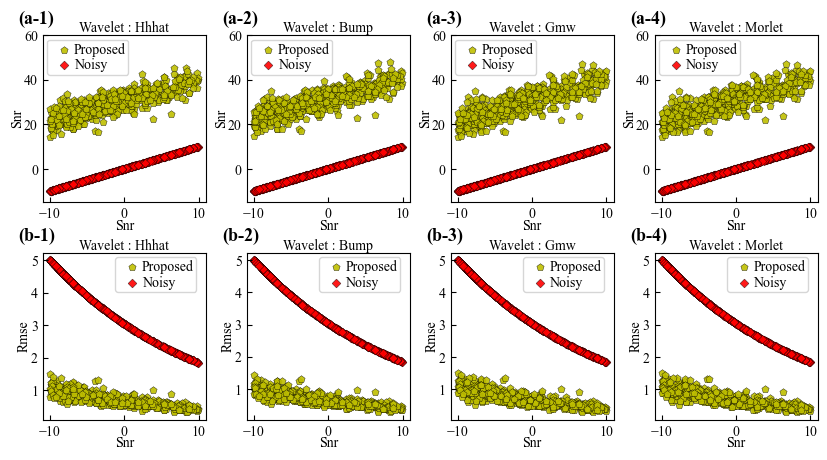

In [ ]:

ln = 0.3
sizes = 30
sizes1 = sizes - 10
axes = []
plt.figure(figsize=(10, 5))
for i in range(len(Wav)):

    ax1= plt.subplot(2, 4, i+1)
 
    plt.scatter(SN, P_SN[i, :],c='y', marker='p',s=sizes, alpha=0.9, 
                edgecolors='black', linewidths=ln, label='Proposed')
    plt.scatter(SN, SN, s=sizes1, c='r', marker="D", alpha=0.9, 
                edgecolors='black', linewidths=ln, label='Noisy')
    plt.xlabel('Snr', labelpad=-2)
    plt.ylabel('Snr', labelpad=0)
    plt.title('Wavelet : '+Wav[i], pad=-5)
    plt.ylim([-15, 60])
    
    plt.legend(loc='upper left', 
               bbox_to_anchor=(0.02, 0.98),  # 
               borderaxespad=0.1,  
               borderpad=0.2,      
               handletextpad=-0.3,  
               labelspacing=0.1)  


    ax2 = plt.subplot(2, 4, i+5)
    plt.scatter(SN, P_VA[i, :], c='y',marker='p',s=sizes, alpha=0.9, 
                edgecolors='black', linewidths=ln, label='Proposed')
    plt.scatter(SN, VA, s=sizes1, c='r', marker="D", alpha=0.9, 
                edgecolors='black', linewidths=ln, label='Noisy')
    plt.xlabel('Snr', labelpad=-2)
    plt.ylabel('Rmse', labelpad=0)
    plt.title('Wavelet : '+Wav[i], pad=-5)
 
    
    plt.legend(loc='upper right', 
               bbox_to_anchor=(0.95, 0.98),  
               borderaxespad=0.1,  
               borderpad=0.2,      
               handletextpad=-0.3,  
               labelspacing=0.1)   
    
    axes.append((ax1, ax2))

labels = ['(a-1)', '(a-2)', '(a-3)', '(a-4)', '(b-1)', '(b-2)', '(b-3)', '(b-4)']
for i, (ax1, ax2) in enumerate(axes):
 
    ax1.text(-0.15, 1.15, labels[i], transform=ax1.transAxes, fontsize=NN+3,
            weight='bold', color='black', va='top', ha='left')
  
    ax2.text(-0.15, 1.15, labels[i+4], transform=ax2.transAxes, fontsize=NN+3,
            weight='bold', color='black', va='top', ha='left')

plt.subplots_adjust(wspace=0.25,hspace=0.3)

# plt.savefig("fig15.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()
